# Выбор локации для скважины

Перед нами стоит главная цель - определить где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Для этого мы будем предерживаться следующих ключевых пунктов: 

- В избранном регионе ведутся поиски месторождения, для каждого из которых определяют значения признаков;
- Построим модель и оценим объём запасов;
- Выберем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Для этого построим  модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, Normalizer
import matplotlib.pyplot as plt
from numpy.random import RandomState

In [2]:
data = pd.read_csv('/datasets/geo_data_0.csv')

In [3]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')

In [4]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
def prepare(df): #фунция предобработки данных
    print(df.head())
    print(df.info())
    print(df.isna().sum())
    print(df.duplicated().sum())
    df.hist()
    print(plt.show)

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
0
<function show at 0x7f9e648bce50>
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.9

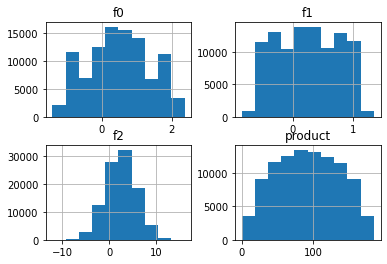

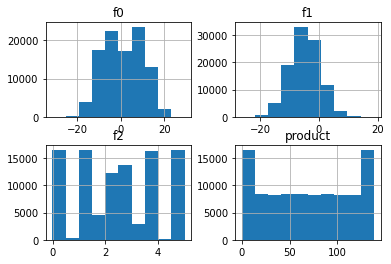

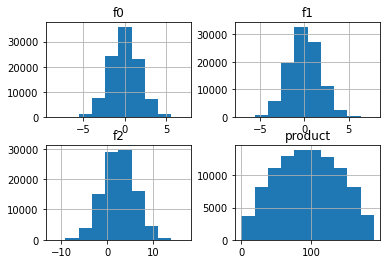

In [6]:
prepare(data)
prepare(data_1)
prepare(data_2)

**Вывод:** данные без пропусков, изучены.

In [7]:
print(data.corr())
print(data_1.corr())
data_2.corr()

               f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000
               f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Проверили данные на **корреляцию** и признак f2 коррелирует с ключевые признаком более чем 0.5 в первом регионе.

## Обучение и проверка модели

In [8]:
def modeling(df): #функция по обучению модели и расчета ее оценочных параметров 
    x = df.drop(['product', 'id'], axis=1)
    y = df['product']
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=12345)
    model = LinearRegression()
    model.fit(x_train, y_train)
    pred_val = model.predict(x_valid)
    mse = mean_squared_error(y_valid, pred_val)
    print('средний запас предсказанного сырья:', pred_val.mean())
    print('RMSE:', mse ** 0.5)
    return y, pred_val, y_valid

In [9]:
target, probabilities, target_valid = modeling(data)
target_1, probabilities_1, target_valid_1 = modeling(data_1)
target_2, probabilities_2, target_valid_2 = modeling(data_2)

средний запас предсказанного сырья: 92.59256778438035
RMSE: 37.5794217150813
средний запас предсказанного сырья: 68.728546895446
RMSE: 0.893099286775617
средний запас предсказанного сырья: 94.96504596800489
RMSE: 40.02970873393434


**Вывод:** средний запас топлива в нулевом и втором регионе велик, во первом - достаточно ниже. Ошибка наименьшая в первом регионе.

## Подготовка к расчёту прибыли

In [10]:
PRICE_PER_BARREL = 450e3

In [11]:
BUDGET = 10**10

In [12]:
min_resurse_oil = BUDGET / PRICE_PER_BARREL / 200 #минимальный объем нефти в разрабатываемых нами 200 скважинах
print('Точка безубыточности:', round(min_resurse_oil, 2))

Точка безубыточности: 111.11


In [13]:
def compare_oil_200(probabilities): #функция сравнения запасов сырья в 200 наилучших
    m = (pd.Series(probabilities).sort_values(ascending=False)[:200].mean() / min_resurse_oil)
    return m

In [14]:
oil_200 = compare_oil_200(probabilities)
oil_1_200 = compare_oil_200(probabilities_1)
oil_2_200 = compare_oil_200(probabilities_2)

In [15]:
def compare_oil(probabilities): #функция сравнения запасов сырья в 200 наилучших
    m = (probabilities.mean()/ min_resurse_oil) *100
    return m

In [16]:
oil = compare_oil(probabilities)
oil_1 = compare_oil(probabilities_1)
oil_2 = compare_oil(probabilities_2)

**Вывод:** если сравнивать точку безубыточности с запасом топлива в 200 наиболее богатых по запасам скважинах, то в нулевом регионе запас больше на 40%, в первом на 25 и во втором на 33, соответственно. Если же сравнивать со средним показателем запасов по региону и точкой безубыточности, то окажется, что в каждом регионе среднее количество запасов нефти, ниже точки безубыточности, все средние запасы ниже 100 тыс баррелей, а точка безубыточности - 111,(1) тыс баррелей.

## Расчёт прибыли и рисков 

In [17]:
#функция расчета прибыли

def profit(target_r, probabilities, count = 200):
    probs_sorted = pd.Series(probabilities).sort_values(ascending=False)[:count]
    target_sort = (target_r.reset_index(drop = True)[probs_sorted.index])
    sum_tar = target_sort.sum() 
    return round((sum_tar * PRICE_PER_BARREL) - BUDGET,2) 

In [18]:
prof = profit(target_valid,  probabilities)
prof_1 = profit(target_valid_1,  probabilities_1)
prof_2 = profit(target_valid_2,  probabilities_2)

In [19]:
display(prof)
display(prof_1)
prof_2

3320826043.14

2415086696.68

2710349963.6

In [20]:
#процедура Bootsstrep
def bootsy(target_b, probabilities, n=500):
    state = np.random.RandomState(12345)  
    values = []
    for i in range(1000):
        sample = pd.Series(probabilities).sample(n, replace=True, random_state=state)# < напишите код здесь>
        values.append(profit(target_b, sample))
    values = pd.Series(values)
    print('Средняя прибыль:', values.mean())
    print('Риск убытков:', values.apply(lambda x: x < 0).sum()/len(values)*100,"%")
    print('2.5%-квантиль:', (int(np.percentile(values, 2.5))))
    print('97.5%-квантиль:', (int(np.percentile(values, 97.5))))

In [21]:
total = bootsy(target_valid, probabilities)
total_1 = bootsy(target_valid_1, probabilities_1)
total_2 = bootsy(target_valid_2, probabilities_2)

Средняя прибыль: 396164984.80228
Риск убытков: 6.9 %
2.5%-квантиль: -111215545
97.5%-квантиль: 909766941
Средняя прибыль: 456045105.78665996
Риск убытков: 1.5 %
2.5%-квантиль: 33820509
97.5%-квантиль: 852289453
Средняя прибыль: 404403866.56838
Риск убытков: 7.6 %
2.5%-квантиль: -163350413
97.5%-квантиль: 950359574


**Вывод:** наибольшая средняя прибыль наблюдается в первом регионе, также там наименьший процент риска убытков, т.е. этот регион наиболее благоприятный для разработок.